# Notebook to compare different runs varying coupling constants
## Gather Plaquette, polyakov loop and Acceptance 
Author: Venkitesh Ayyar (vayyar@bu.edu) \
May 4, 2023

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sqlite3

import subprocess as sp
import os 
import glob
import pandas as pd
import itertools
import yaml
import sys

In [3]:
import gvar as gv

In [4]:
# %matplotlib widget

In [5]:
%matplotlib notebook

In [6]:
sys.path.append('modules')
from modules_parse_hmc_Grid import *
from modules_measurement import *


$$ \chi_\mathcal{O} = L^3 \left[ \langle \mathcal{O}^2 \rangle - {(\langle \mathcal{O} \rangle )}^2 \right] = L^3 \langle (\mathcal{O} - \bar{\mathcal{O}})^2\rangle $$ 

$$ \kappa_\mathcal{O} = \frac{\langle \mathcal{O}^4 \rangle - 4 \langle \mathcal{O}^3 \rangle \langle \mathcal{O} \rangle +6 \langle \mathcal{O}^2 \rangle {\langle \mathcal{O} \rangle} ^2 - 3 {\langle \mathcal{O} \rangle}^4 }{\chi_\mathcal{O}^2} = \frac{ \langle \left( \mathcal{O-\bar{\mathcal{O}}} \right) ^4 \rangle }{\chi_\mathcal{O}^2}$$ 

In [7]:
def f_get_run_info_dict(dict1,input_dict,run_label):
    '''   
    Get dictionary with run info that will be added to Dataframe as columns
    '''
    keys=['Lx','Lt','beta','mf']
    for key in keys:
        dict1[key]=input_dict[key]
    
    run_key='beta-%s_mf-%s_Lx-%s_Lt-%s'%(input_dict['beta'],input_dict['mf'],input_dict['Lx'],input_dict['Lt'])
    
    if input_dict['F_action'] =='Mobius_dwf': ## Add Ls in label for DWF
        keys.append('dwf_Ls')
    
        
    run_key='beta-%s_mf-%s_Lx-%s_Lt-%s'%(input_dict['beta'],input_dict['mf'],input_dict['Lx'],input_dict['Lt'])
            
    if input_dict['F_action'] =='Mobius_dwf': ## Add Ls in label for DWF
        run_key+='_Ls-%s'%(input_dict['dwf_Ls'])

    dict1['run_label'] = run_label
    run_key+='_'+run_label 
    
    dict1['run_key']   = run_key
        
    return dict1

## Read from HMC table

In [8]:
def f_get_hmc_data(dict1,fname1):
    '''
    Given a dictionary, extract the time series for just that set of couplings
    '''

    sql_query='SELECT * FROM test \
    WHERE Lx={Lx} \
    AND Lt={Lt} \
    AND mf={mf} \
    AND beta IN{beta}\
    '.format(**dict1)
    
    print(sql_query)
    
    conn = sqlite3.connect(fname1)
    df_read=pd.read_sql_query(sql_query,conn)
    df_read['Polyakov']=df_read['Polyakov'].astype(np.complex128)
    conn.close()
    
    return df_read



In [9]:
fname1='Stored_data/sql_dbase_files/parsed_hmc_1.db'

dict1={'Lx':16, 'Lt':8,'mf':0.1,  'beta':(10.4,10.9,11.6,12.0) }

df_hmc=f_get_hmc_data(dict1,fname1)
df_hmc

SELECT * FROM test     WHERE Lx=16     AND Lt=8     AND mf=0.1     AND beta IN(10.4, 10.9, 11.6, 12.0)    


,Plaquette,iter,Polyakov,Traj_time,Accept,Lx,Lt,beta,mf,run_label,run_key
0,0.222102,1.0,0.000789-0.004429j,102.355003,NaN,16,8,10.4,0.1,hot-start,beta-10.4_mf-0.1_Lx-16_Lt-8_Ls-16_hot-start
1,0.308305,2.0,0.001309+0.003469j,125.177002,NaN,16,8,10.4,0.1,hot-start,beta-10.4_mf-0.1_Lx-16_Lt-8_Ls-16_hot-start
2,0.353681,3.0,0.000139-0.004692j,135.501999,NaN,16,8,10.4,0.1,hot-start,beta-10.4_mf-0.1_Lx-16_Lt-8_Ls-16_hot-start
3,0.381649,4.0,-0.003642-0.000213j,138.735992,NaN,16,8,10.4,0.1,hot-start,beta-10.4_mf-0.1_Lx-16_Lt-8_Ls-16_hot-start
4,0.400802,5.0,0.001472-0.002601j,141.481003,NaN,16,8,10.4,0.1,hot-start,beta-10.4_mf-0.1_Lx-16_Lt-8_Ls-16_hot-start
...,...,...,...,...,...,...,...,...,...,...,...
9380,0.570527,2068.0,-0.024294-0.002643j,89.158997,1.0,16,8,10.9,0.1,cold-start,beta-10.9_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start
9381,0.570479,2069.0,-0.025479-0.003573j,88.913498,1.0,16,8,10.9,0.1,cold-start,beta-10.9_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start
9382,0.570449,2070.0,-0.028548-0.001227j,88.910103,1.0,16,8,10.9,0.1,cold-start,beta-10.9_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start
9383,0.571357,2071.0,-0.031845-0.002337j,89.696198,1.0,16,8,10.9,0.1,cold-start,beta-10.9_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start


## Read summary HMC data from table

In [10]:
def f_conv_strg_to_gvar(x):
    '''
    convert entry from string to gvar
    '''
    try :
        ans=gv.gvar(x)
    except Exception as e:
        ans=gv.gvar(np.nan,np.nan)
        
    return ans

In [11]:
### Read sql database
fname2='Stored_data/sql_dbase_files/summary_hmc_data_1.db'
conn = sqlite3.connect(fname2)
df_summary=pd.read_sql_query("SELECT * FROM summary",conn)


# # Convert strings to gvars for analysis
gvar_key_list=['plaq', 'sus_plaq', 'kurt_plaq', 'polyakov', 'sus_poly', 'kurt_poly', 'traj_time']
for key in gvar_key_list:        
#     df_summary[key] = df_summary[key].apply(lambda x: gv.gvar(x))
    df_summary[key] = df_summary[key].apply(lambda x: f_conv_strg_to_gvar(x))

In [12]:
df_summary

,beta,mf,Lx,Lt,run_key,run_label,plaq,sus_plaq,kurt_plaq,plaq_autocorr,polyakov,sus_poly,kurt_poly,poly_autocorr,traj_time,accept,num_conf
0,10.0,0.067,24,12,beta-10.0_mf-0.067_Lx-24_Lt-12_Ls-16_hot-start,hot-start,0.413102(27),0.00094(14),1.54(46)e-08,7.0,0.00176(10),0.0136(22),1.84(92)e-08,1.0,559.32(25),65.168539,188.0
1,10.0,0.100,16,8,beta-10.0_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start,cold-start,0.412963(77),0.00208(28),1.53(38)e-07,3.0,0.00389(20),0.0138(17),1.38(26)e-07,1.0,141.294(25),80.864198,172.0
2,10.0,0.100,16,8,beta-10.0_mf-0.1_Lx-16_Lt-8_Ls-16_hot-start,hot-start,0.413407(61),0.00130(16),1.34(32)e-07,3.0,0.00356(18),0.0116(28),3.6(2.3)e-07,1.0,141.410(26),78.125000,170.0
3,10.0,0.100,24,12,beta-10.0_mf-0.1_Lx-24_Lt-12_Ls-16_hot-start,hot-start,0.413501(31),0.00138(21),1.79(57)e-08,4.0,0.001697(87),0.0112(14),1.35(39)e-08,1.0,477.07(13),71.782178,212.0
4,10.0,0.100,24,8,beta-10.0_mf-0.1_Lx-24_Lt-8_Ls-16_hot-start,hot-start,0.413513(44),0.00256(37),1.60(59)e-08,5.0,0.001746(90),0.0109(15),1.43(45)e-08,1.0,336.042(59),71.195652,194.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,13.0,0.100,24,12,beta-13.0_mf-0.1_Lx-24_Lt-12_Ls-16_hot-start,hot-start,0.666585(15),0.000413(43),1.31(23)e-08,3.0,0.04522(17),0.0548(65),1.55(45)e-08,1.0,276.95(21),86.832740,282.0
80,13.5,0.100,24,12,beta-13.5_mf-0.1_Lx-24_Lt-12_Ls-16_cold-start,cold-start,0.681955(16),0.000338(41),1.25(32)e-08,3.0,0.05584(27),0.096(14),1.59(41)e-08,5.0,339.80(16),88.461538,192.0
81,13.5,0.100,24,12,beta-13.5_mf-0.1_Lx-24_Lt-12_Ls-16_hot-start,hot-start,0.682005(15),0.000423(49),1.51(32)e-08,3.0,0.05847(19),0.0730(74),1.29(24)e-08,2.0,267.63(15),86.013986,286.0
82,14.0,0.100,24,12,beta-14.0_mf-0.1_Lx-24_Lt-12_Ls-16_cold-start,cold-start,0.695834(20),0.000505(63),1.28(26)e-08,4.0,0.06728(30),0.116(15),1.33(31)e-08,3.0,339.28(22),86.263736,192.0


## Summary analysis

#### Num confs

In [38]:
df_sliced=df_summary.copy()
df_sliced=df_summary[((df_summary.Lx==16)&(df_summary.Lt==8)&(df_summary.mf==0.1))|((df_summary.Lt==12)&(df_summary.mf==0.067))].copy()
# df_sliced=df_summary[((df_summary.Lx==24)&(df_summary.Lt==12)&(df_summary.mf==0.1))].copy()


<IPython.core.display.Javascript object>


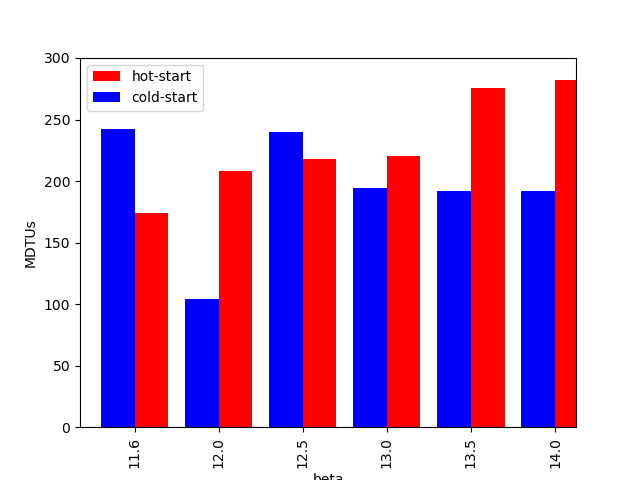

Text(0, 0.5, 'MDTUs')

In [25]:
## Plot number of configs
df=df_sliced[(df_sliced.beta>10.5)&(df_sliced.beta<17.1)&(df_sliced.Lx==24)&(df_sliced.Lt==12)&(df_sliced.mf==0.1)]\
[['Lx','Lt','beta','run_label','num_conf']]
df.set_index('beta',inplace=True)

# display(df)

width=0.4 

plt.figure()

label='hot-start'
df[df.run_label==label].num_conf.plot(kind='bar', width=width, color='red', position=0, label=label)

label='cold-start'
(df[df.run_label==label].num_conf).plot(kind='bar', width=width, color='blue', position=1, label=label)

plt.legend(loc='best')

plt.ylabel("MDTUs")
# plt.savefig('fig_output/num_confs_hot_cold.pdf')


In [40]:
mf_list   = np.sort(np.unique(df_sliced.mf.values))
beta_list = np.sort(np.unique(df_sliced.beta.values))
# Lt_list = np.sort(np.unique(df_sliced.Lt.values))

## Combining Lx and Lt into a label 
L_list=np.unique([str(i)+'_'+str(j)+'_'+str(k) for i,j,k in zip(df_sliced.Lx.values, df_sliced.Lt.values, df_sliced.run_label.values)])
mf_list,beta_list,L_list

(array([0.067, 0.1  ]),
 array([10. , 10.2, 10.4, 10.6, 10.7, 10.8, 10.9, 11. , 11.1, 11.2, 11.3,
        11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12. , 12.5, 13. ]),
 array(['16_8_cold-start', '16_8_hot-start', '24_12_hot-start'],
       dtype='<U15'))

<IPython.core.display.Javascript object>


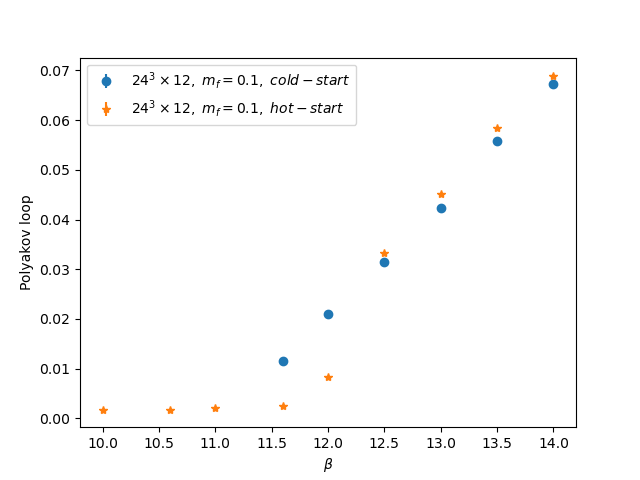

Text(0, 0.5, 'Polyakov loop')

In [29]:
plt.figure()

for (l,marker) in zip(L_list,itertools.cycle('o*d>^sDHPdpx_')):
    lx,lt,run_label=int(l.split('_')[0]),int(l.split('_')[1]),l.split('_')[2]
    df=df_sliced[(df_sliced.Lx==lx)&(df_sliced.Lt==lt)&(df_sliced.run_label==run_label)]
    for mf in mf_list:
#         label='mf=%s_L=%s'%(mf,l)
        label=r'${%s}^3 \times %s ,\ m_f=%s,\ %s$'%(l.split('_')[0],l.split('_')[1],mf,run_label)

        df1=df[df.mf==mf].sort_values(by=['beta'])
#         display(df1)
        
    #     if df1.shape[0]>1:
        x=df1.beta.values
        y=df1.polyakov.values
    #     print(x,y)
        plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
#         plt.plot(x,gv.mean(y),linestyle='',label=label,marker=marker)
        
plt.show()
plt.xlabel(r'$\beta$')
plt.xticks(np.arange(min(beta_list),max(beta_list)+0.2,0.5))
plt.legend()
plt.ylabel('Polyakov loop',rotation='vertical')
# plt.xlim(10.2,11.2)
# plt.ylim(0,0.04)
# plt.savefig('fig_output/Ploop_vs_beta_hot_cold.pdf')

<IPython.core.display.Javascript object>


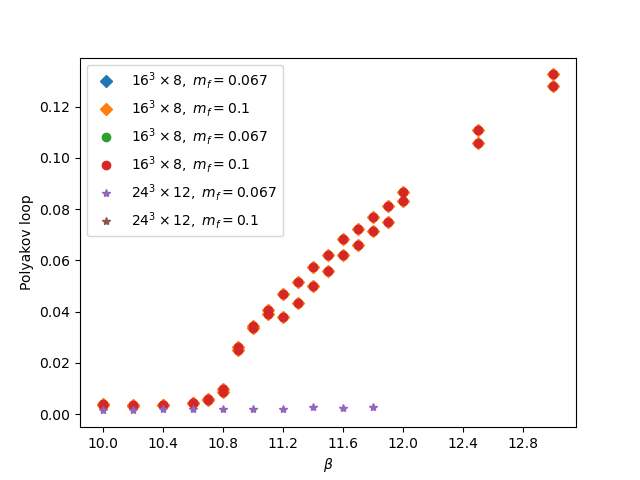

Text(0, 0.5, 'Polyakov loop')

In [42]:
plt.figure()

for (l,marker) in zip(L_list,itertools.cycle('Do*xd>^sDHPdpx_')):
    lx,lt=int(l.split('_')[0]),int(l.split('_')[1])
    df=df_sliced[(df_sliced.Lx==lx)&(df_sliced.Lt==lt)]
    for mf in mf_list:
#         label='mf=%s_L=%s'%(mf,l)
        label=r'${%s}^3 \times %s ,\ m_f=%s$'%(l.split('_')[0],l.split('_')[1],mf)
        df1=df[df.mf==mf].sort_values(by=['beta'])
#         display(df1)
        
    #     if df1.shape[0]>1:
        x=df1.beta.values
        y=df1.polyakov.values
    #     print(x,y)
#         plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        plt.plot(x,gv.mean(y),linestyle='',label=label,marker=marker)

plt.show()
plt.xlabel(r'$\beta$')
plt.xticks(np.arange(min(beta_list),max(beta_list)+0.2,0.4))
plt.legend()
plt.ylabel('Polyakov loop',rotation='vertical')
# plt.xlim(10.2,11.2)
# plt.ylim(0,0.04)
# plt.savefig('fig_output/Ploop_vs_beta_different_Lt.pdf')

In [30]:
df_sliced

,beta,mf,Lx,Lt,run_key,run_label,plaq,sus_plaq,kurt_plaq,plaq_autocorr,polyakov,sus_poly,kurt_poly,poly_autocorr,traj_time,accept,num_conf
3,10.0,0.1,24,12,beta-10.0_mf-0.1_Lx-24_Lt-12_Ls-16_hot-start,hot-start,0.413501(31),0.00138(21),1.79(57)e-08,4.0,0.001697(87),0.0112(14),1.35(39)e-08,1.0,477.07(13),71.782178,212.0
16,10.6,0.1,24,12,beta-10.6_mf-0.1_Lx-24_Lt-12_Ls-16_hot-start,hot-start,0.547085(25),0.00076(11),1.50(36)e-08,2.0,0.00178(10),0.0123(16),1.25(47)e-08,1.0,403.18(60),84.756098,174.0
30,11.0,0.1,24,12,beta-11.0_mf-0.1_Lx-24_Lt-12_Ls-16_hot-start,hot-start,0.578133(25),0.00088(14),1.89(77)e-08,3.0,0.00217(11),0.0189(27),1.60(49)e-08,1.0,330.45(50),87.878788,208.0
54,11.6,0.1,24,12,beta-11.6_mf-0.1_Lx-24_Lt-12_Ls-16_cold-start,cold-start,0.611478(19),0.000577(75),1.58(40)e-08,2.0,0.01149(17),0.0467(60),1.55(38)e-08,1.0,323.719(91),84.848485,242.0
55,11.6,0.1,24,12,beta-11.6_mf-0.1_Lx-24_Lt-12_Ls-16_hot-start,hot-start,0.611437(26),0.00101(13),1.40(32)e-08,3.0,0.00258(14),0.0276(53),2.6(1.3)e-08,1.0,320.192(82),87.922705,218.0
69,12.0,0.1,24,12,beta-12.0_mf-0.1_Lx-24_Lt-12_Ls-16_cold-start,cold-start,0.629600(32),0.00074(10),1.01(26)e-08,4.0,0.02098(31),0.071(12),1.31(41)e-08,3.0,327.214(81),83.606557,104.0
70,12.0,0.1,24,12,beta-12.0_mf-0.1_Lx-24_Lt-12_Ls-16_hot-start,hot-start,0.629524(20),0.000601(74),1.39(30)e-08,2.0,0.00831(30),0.140(17),1.40(33)e-08,10.0,313.78(61),86.602871,220.0
74,12.5,0.1,24,12,beta-12.5_mf-0.1_Lx-24_Lt-12_Ls-16_cold-start,cold-start,0.649214(17),0.000457(58),1.53(34)e-08,2.0,0.03141(29),0.139(16),1.40(32)e-08,16.0,328.24(13),82.532751,240.0
75,12.5,0.1,24,12,beta-12.5_mf-0.1_Lx-24_Lt-12_Ls-16_hot-start,hot-start,0.649383(20),0.000737(94),1.68(36)e-08,5.0,0.03324(22),0.089(12),1.74(50)e-08,2.0,276.71(18),83.695652,276.0
78,13.0,0.1,24,12,beta-13.0_mf-0.1_Lx-24_Lt-12_Ls-16_cold-start,cold-start,0.666552(20),0.000537(51),9.8(1.5)e-09,4.0,0.04235(32),0.137(26),2.3(1.2)e-08,6.0,334.64(11),83.060109,194.0
